# Obliczenie dokładności na całych obrazach

### Wczytywanie koordynatów rzeczywistych i przewidzianych dla wszystkich obrazów

In [1]:
from validating_all_images import unpickle_data

In [2]:
coords = unpickle_data("combined_coords_greater_neg3.pickle")

In [3]:
import numpy as np
coords = np.array(coords, dtype=object)

Pierwsza wartość to liczba wierszy, czyli liczba sprawdzonych obrzków.
Druga wartość to liczba kolumn. Pierwsza kolumna to nazwa pliku, druga kolumna to rzeczywiste bounding_boxes wczytane z plików, trzecia kolumna to bounding_boxes wraz z wartościami decyzji z detekcji na naszym modelu RealBoost.

In [4]:
coords.shape

(2845, 3)

Pierwsza kolumna - nazwa pliku. Przyda się do późniejszego rysowania prostokątów.

In [5]:
coords[0][0]

'c:/Dev/machine_learning_2/data/2002/08/11/big/img_591.jpg'

Druga kolumna - rzeczywiste bounding boxes. W formacie:

```
np.array([j0, k0, j0 + w - 1, k0 + w - 1])
```

Aby wyrysować taki bounding box będziemy używać:

```
p1 = (k0, j0)
p2 = (k0 + w - 1, j0 + w - 1)
cv2.rectangle(i0, p1, p2, (0, 0, 255), 1)
cv2.imshow("FDDB", i0)
```

In [6]:
coords[0][1]

[array([ 69, 177, 253, 361])]

Trzecia kolumna - wykryte bounding boxes. Do rysowania tych bounding boxów użyjemy funkcji `draw_bounding_boxes`.

```
i0 = draw_bounding_boxes(i0, detections, color=(54, 193, 56), thickness=1)
cv2.imshow("FDDB", i0)
cv2.waitKey(0)
```

In [22]:
coords[0][2][:10]

[(145, 0, 64, -1.7471035835211806),
 (151, 0, 64, -1.7401845792751047),
 (157, 0, 64, -0.33458332775921035),
 (163, 0, 64, -2.0132834873671364),
 (169, 0, 64, -2.904642011056758),
 (175, 0, 64, -2.9146254938229244),
 (181, 0, 64, -2.456179953629234),
 (187, 0, 64, -1.086222616561942),
 (193, 0, 64, -1.7767805136272046),
 (199, 0, 64, -1.7679027610115994)]

### Uśrednianie wykrytych prostokątów

#### Progowanie

Wykryte prostokąty należy najpierw sprogować, czyli przefiltrować po danym progu. Wszystkie wykryte prostokąty to takie z wartością funkcji decyzyjnej $\gt 0$. Czemu tak? Żeby wygenerować wszystkie dane i móc sterować progiem decyzyjnym już po przeanalizowaniu wszystkich obrazków.

In [8]:
def reduce_by_threshold(image_row, **kwargs):
    threshold = kwargs['threshold']
    detections = np.array(image_row[2])
    if detections.ndim == 1:
        return (image_row[0], image_row[1], detections)
    
    detections_reduced = detections[np.where(detections[:, 3] > threshold)].astype('int')
    return (image_row[0], image_row[1], detections_reduced)

coords_filtered = np.apply_along_axis(reduce_by_threshold, 1, coords, threshold=2.5)

c:\dev\machine_learning_2\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


#### Uśrednianie

Uśrednianie prostokątów już po filtracji wybranym progiem.

In [9]:
from haar_students_new import non_max_suppression

def bounding_boxes_reduction(image_row):
    detections = image_row[2]
    detections_reduced = non_max_suppression(detections, treshold=0.1)
    return (image_row[0], image_row[1], detections_reduced)

coords_suppresion = np.apply_along_axis(bounding_boxes_reduction, 1, coords_filtered)

### Obliczanie dokładności na danych

Dla każdego uśrednionego prostokąta sprawdzamy czy się pokrywa z innym zgodnie z wymaganiem `iou > 0.5`. 

In [10]:
from haar_students_new import iou

def calculate_metrics(image_row):
    preds = image_row[2]
    reals = image_row[1]
    preds = [[j, k, j+w, k+w] for (k, j, w, _) in preds]
    
    p = len(reals)
    fn = 0
    # calculate false negatives
    for real in reals:
        found_prediction = False
        for pred in preds:
            if iou(real, pred) > 0.5:
                found_prediction = True
                break
        if not found_prediction:
            fn += 1
    
    tp = 0
    fp = 0
    # calculate true positives and false positives
    for pred in preds:
        found_real = False
        for real in reals:
            if iou(real, pred) > 0.5:
                found_real = True
                break
        if found_real:
            tp += 1
        else:
            fp += 1
                
    
    return tp, fp, fn, p

### Test czy dobrze zlicza tp, fp, fn, p

In [11]:
coords_suppresion[:, 2]

array([list([(178, 121, 77, 3)]),
       list([(48, 25, 111, 5), (291, 75, 92, 3), (330, 156, 64, 2)]),
       list([]), ..., list([(132, 138, 64, 3), (103, 48, 92, 3)]),
       list([(70, 104, 111, 5), (246, 102, 92, 4), (48, 54, 64, 2)]),
       list([])], dtype=object)

In [12]:
coords_suppresion[0]

array(['c:/Dev/machine_learning_2/data/2002/08/11/big/img_591.jpg',
       list([array([ 69, 177, 253, 361])]), list([(178, 121, 77, 3)])],
      dtype=object)

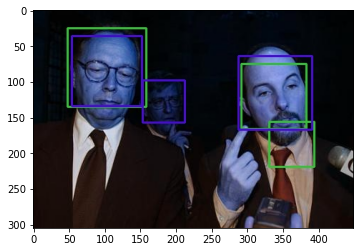

In [13]:
import cv2
i = cv2.imread(coords_suppresion[1][0] + "_detection.jpg")
import matplotlib.pyplot as plt
plt.imshow(i)

Mam taki problem z naszym zadaniem, gdzie mamy przeprowadzić badania dla całych obrazów. Jak obliczyć dokładność? 

Gdzie widzę problem? W tym, że na obrazach nie możemy zliczyć ile jest próbek negatywnych. Popatrzcie na przykładowy obrazek. Na czerwono zaznaczona jest prawda, na zielono detekcja.

Mogę obliczyć *True Positive* - są to dobrze sklasyfikowane jako pozytywne - będą to dwie twarze kobiet. 

Mogę obliczyć *False Negative* - jest to twarz dziecka, która fałszywie została oznaczona jako negatywna, a powinna być pozytywna.

I mogę też obliczyć *False Positive* - jest to prostokąt obejmujący ramię kobiety. 

Wiem też jaka jest ogólna liczba prawdziwych pozytywów *P* - są to trzy prostokąty.

Z tego mogę obliczyć czułość, jako `1 - FN/P`. [https://www.wikiwand.com/en/Sensitivity_and_specificity]

Ale jak obliczyć FAR (FPR) `FAR = FP/N = 1 - TN/N`? I jak obliczyć dokładność: `ACC = (TP+TN)/(P+N)`

In [14]:
coords_suppresion[1]

array(['c:/Dev/machine_learning_2/data/2002/08/26/big/img_265.jpg',
       list([array([ 36,  54, 136, 154]), array([ 98, 153, 159, 214]), array([ 64, 287, 169, 392])]),
       list([(48, 25, 111, 5), (291, 75, 92, 3), (330, 156, 64, 2)])],
      dtype=object)

In [15]:
calculate_metrics(coords_suppresion[1])
# tp, fp, fn, p

(2, 1, 1, 3)

In [16]:
metrics = np.array([calculate_metrics(image_row) for image_row in coords_suppresion])
num_of_images = metrics.shape[0]
metrics_summary = metrics.sum(axis=0)

In [17]:
num_of_images

2845

In [18]:
tp, fp, fn, p = metrics_summary

In [19]:
sensitivity = 1 - fn/p
sensitivity

0.4967962409226826

In [20]:
far = fp/num_of_images
far

1.1360281195079087

## Wizualizacja - zapisywanie obrazów z detekcją

In [21]:
import cv2
from haar_students_new import draw_bounding_boxes

def batch_drawing(image_row):
    file_path = image_row[0]
    ground_truth = image_row[1]
    detections = image_row[2]
    ground_truth = [[bb[1], bb[0], bb[2] - bb[0] - 1, None] for bb in ground_truth]
    
    i = cv2.imread(file_path)
    i = draw_bounding_boxes(i, detections, color=(54, 193, 56), thickness=2)
    i = draw_bounding_boxes(i, ground_truth, color=(70, 8, 210), thickness=2)
    
    cv2.imwrite(file_path+"_detection.jpg", i)
    
    # print(file_path, len(ground_truth), len(detections))

np.apply_along_axis(batch_drawing, 1, coords_suppresion).shape

(2845,)